<a href="https://colab.research.google.com/github/taravatp/roadLane_InstanceSegmentation/blob/main/train/HNet_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages and import them

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Lane_Detection/

/content/drive/MyDrive/Lane_Detection


In [ ]:
!pip install import_ipynb 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=46551ebae1b5b849a7e4d03958bc42b88299765b7c50a20b9b3d7b59877dfb04
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os.path as ops
import time
import import_ipynb
from torch.autograd import Variable

from dataset.dataset_Hnet import HNet_dataset
from models.Hnet import Hnet

# Hnet Loss function

In [ ]:
class HNet_loss(nn.Module):
  def __init__(self):
    super(HNet_loss,self).__init__()

  def forward(self,gt_points, predicted_coef):
    batch_size = predicted_coef.shape[0]
    hnet_loss = torch.tensor(0.).to(device)
    for dimen in range(batch_size):
      hnet_loss += self.hnet_loss(gt_points,predicted_coef)
    return hnet_loss/batch_size;
  
  def hnet_loss(self,gt_points,predicted_coef):

    gt_points = gt_points.view(-1,3)
    predicted_coef = predicted_coef.view(6).to(device)

    #creating H matrix
    predicted_coef = torch.cat([predicted_coef, torch.tensor([1.0]).to(device)])
    H_indices = torch.tensor([0, 1, 2, 4, 5, 7, 8], dtype=torch.long).to(device)
    H = torch.zeros(9, dtype=torch.float32).to(device)
    H = H.scatter_(0, H_indices, predicted_coef)
    H = H.view(3,3).to(device)
    
    #calculating H*gt_points
    gt_points = gt_points.to(torch.float32).t() #transposes the tensor 
    projected_points = torch.mm(H,gt_points) #matrix multiplication

    projected_X = projected_points[0,:].view(-1,1) #putting x indices in a vector
    projected_Y = projected_points[1,:].view(-1,1) #putting y indices in a vector

    #careting Y matirx
    Y_matrix = torch.cat([torch.pow(projected_Y,3), torch.pow(projected_Y,2), projected_Y,torch.ones_like(projected_Y,dtype=torch.float32)],dim=1)
    #calculating w
    w = torch.mm(Y_matrix.t(),Y_matrix).inverse().mm(Y_matrix.t()).mm(projected_X)
    
    #predicted x
    x_pred = torch.mm(Y_matrix, w)  # (n * 1)
    #predicted x and y
    predicted_points = torch.cat([x_pred, projected_Y, torch.ones_like(projected_Y, dtype=torch.float32)], dim=1).t()  # (3 * n)
    #reproject
    reprojected_points = torch.mm(H.inverse(), predicted_points)
    #calculate loss usin mean squared error

    loss = torch.mean(torch.pow(reprojected_points[0, :] - predicted_points[0, :], 2))
    return loss;


In [ ]:
train_set = HNet_dataset('train')
batch_size = 1
data_loader_train = DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=2)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Hnet_model = Hnet()
Hnet_model.to(device)

learning_rate = 5e-2
params = [p for p in Hnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_function = HNet_loss()
num_epochs = 200

In [ ]:
Hnet_loss = []

for epoch in range(num_epochs):
  Hnet_model.train()
  ts = time.time()
  for iter,batch in enumerate(data_loader_train):

    gt_image = Variable(batch[0]).to(device)
    gt_points = Variable(batch[1]).to(device)

    predicted_coef = Hnet_model(gt_image)
    loss = loss_function(gt_points = gt_points ,predicted_coef = predicted_coef)
    Hnet_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if iter%400 == 0:
      print("epoch={} , iter= {} , Hnet_loss={}".format(epoch,iter,loss))

  lr_scheduler.step()
  print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
  torch.save(Hnet_model.state_dict(), f"Hnet_model{epoch}_batch_{batch_size}.pth")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch=0 , iter= 0 , Hnet_loss=1725.78173828125
epoch=0 , iter= 400 , Hnet_loss=268203.3125
epoch=0 , iter= 800 , Hnet_loss=6836.052734375
epoch=0 , iter= 1200 , Hnet_loss=8934.931640625
epoch=0 , iter= 1600 , Hnet_loss=46098.4140625
epoch=0 , iter= 2000 , Hnet_loss=81639.1015625
epoch=0 , iter= 2400 , Hnet_loss=66239.84375
epoch=0 , iter= 2800 , Hnet_loss=457700.4375
Finish epoch[0], time elapsed[741.2354283332825]
epoch=1 , iter= 0 , Hnet_loss=153299.390625
epoch=1 , iter= 400 , Hnet_loss=38501.30859375
epoch=1 , iter= 800 , Hnet_loss=235405.328125
epoch=1 , iter= 1200 , Hnet_loss=84836.6953125
epoch=1 , iter= 1600 , Hnet_loss=91342.3515625
epoch=1 , iter= 2000 , Hnet_loss=1231982.125
epoch=1 , iter= 2400 , Hnet_loss=156422.59375
epoch=1 , iter= 2800 , Hnet_loss=255593.75
Finish epoch[1], time elapsed[65.91449451446533]
epoch=2 , iter= 0 , Hnet_loss=303280.78125
epoch=2 , iter= 400 , Hnet_loss=283174.28125
epoch=2 , iter= 800 , Hnet_loss=3841664.75
epoch=2 , iter= 1200 , Hnet_loss=119

KeyboardInterrupt: ignored

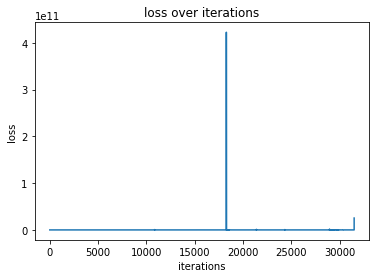

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.title('loss over iterations')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(Hnet_loss)

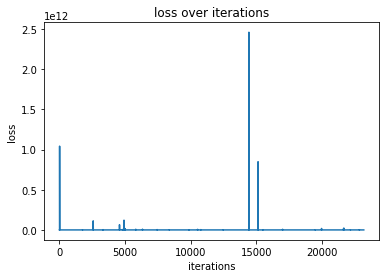

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
plt.title('loss over iterations')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(Hnet_loss)

In [ ]:
print(learning_rate)

0.0005
